#Requirements

In [1]:
!pip install tqdm
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.8 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from imblearn.over_sampling import SMOTE
from scipy.linalg import svdvals
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Dataset

In [3]:
dataset_label = {
  0 : "Cobaltstrike",
  1 : "Bruteratel",
  2 : "Covenant",
  3 : "Deimos",
  4 : "Sliver",
  5 : "Posh",
  6 : "Metsploit"
}

In [4]:
unbalanced_dataset = pd.read_csv("result.csv")
unbalanced_dataset["label"] = unbalanced_dataset.label.astype("int64")
unbalanced_dataset

,data,node,edge,label
0,Adobe_XMP_Identifier SizeofResource WriteProce...,411,426,1
1,T1129 T1569.002 ChangeServiceConfig2A ChangeSe...,0,0,1
2,T1213 T1056.001 T1222 T1562.004 T1112 T1027.00...,0,0,1
3,brc4_shellcode HKTL_BruteRatel_Badger_Indicato...,0,0,1
4,ExitProcess HeapSize UnhandledExceptionFilter ...,0,0,1
...,...,...,...,...
429,WriteFile WriteConsoleW WaitForSingleObject Vi...,0,0,4
430,WriteFile WriteConsoleW WaitForSingleObject Vi...,0,0,4
431,WriteFile WriteConsoleW WaitForSingleObject Vi...,0,0,4
432,WriteFile WriteConsoleW WaitForSingleObject Vi...,0,0,4


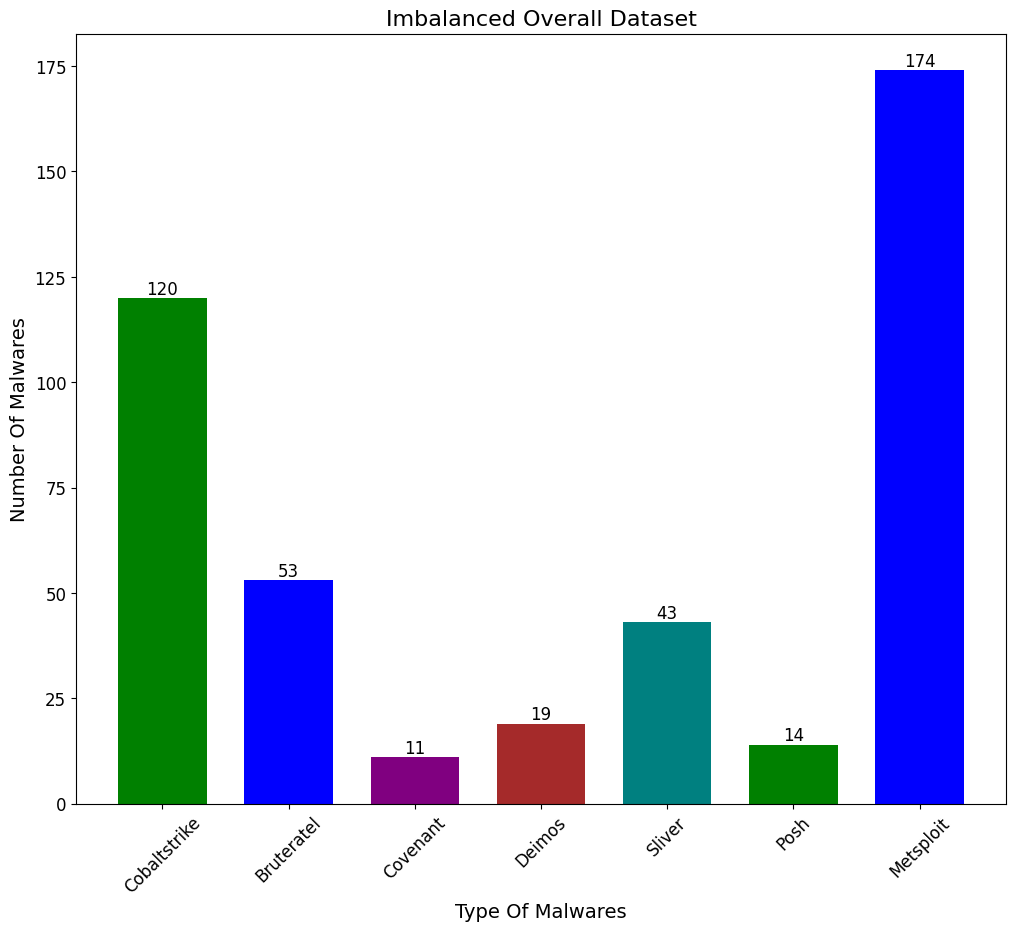

In [5]:
unbalanced_dataset_size = unbalanced_dataset["label"].value_counts().to_dict()
unbalanced_dataset_size = {k: v for k, v in sorted(list(unbalanced_dataset_size.items()))}

names = list(dataset_label.values())
values = list(unbalanced_dataset_size.values())
New_Colors = ["green","blue","purple","brown","teal"]
plt.figure(figsize=(12,10))
plt.bar(names,values,color=New_Colors,width=0.7)

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, fontsize= 12)
plt.yticks(fontsize= 12)
plt.title("Imbalanced Overall Dataset",fontsize=16)
plt.xlabel("Type Of Malwares", fontsize=14)
plt.ylabel("Number Of Malwares", fontsize=14)
plt.show()

#Word Embedding

Word2Vec

In [6]:
def api_sequence_to_vector(api_sequence, model, v_size):
    vector = []
    for api in api_sequence[:v_size]:
        if api in model.wv:
            vector.append(model.wv[api])
        else:
            vector.append([0] * v_size)

    # Padding
    while len(vector) < v_size:
        vector.append([0] * v_size)

    return vector

In [7]:
unbalanced_dataset["data"] = unbalanced_dataset["data"].str.split()
unbalanced_dataset

,data,node,edge,label
0,"[Adobe_XMP_Identifier, SizeofResource, WritePr...",411,426,1
1,"[T1129, T1569.002, ChangeServiceConfig2A, Chan...",0,0,1
2,"[T1213, T1056.001, T1222, T1562.004, T1112, T1...",0,0,1
3,"[brc4_shellcode, HKTL_BruteRatel_Badger_Indica...",0,0,1
4,"[ExitProcess, HeapSize, UnhandledExceptionFilt...",0,0,1
...,...,...,...,...
429,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4
430,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4
431,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4
432,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4


In [8]:
model = Word2Vec(unbalanced_dataset["data"], vector_size=32, window=5, min_count=1, sg=0, epochs=50)

In [9]:
vec_dim = 32
unbalanced_dataset["data_matrix"] = unbalanced_dataset["data"].apply(lambda x: api_sequence_to_vector(x, model, vec_dim))
unbalanced_dataset = unbalanced_dataset.drop(columns=["data"])
unbalanced_dataset

,node,edge,label,data_matrix
0,411,426,1,"[[-0.036219493, 0.17739548, -0.051511098, -0.2..."
1,0,0,1,"[[-0.28812593, 2.2340105, 1.5526513, -1.898062..."
2,0,0,1,"[[-0.110663846, -0.1095305, -0.0015560886, 0.0..."
3,0,0,1,"[[-1.1489253, -1.4427993, 1.2057248, 1.2089112..."
4,0,0,1,"[[-2.0908442, 4.3294, 0.11259346, 0.46706516, ..."
...,...,...,...,...
429,0,0,4,"[[-1.8608919, 2.162414, 4.7864804, -3.1802223,..."
430,0,0,4,"[[-1.8608919, 2.162414, 4.7864804, -3.1802223,..."
431,0,0,4,"[[-1.8608919, 2.162414, 4.7864804, -3.1802223,..."
432,0,0,4,"[[-1.8608919, 2.162414, 4.7864804, -3.1802223,..."


SVD

In [10]:
def calculate_eigenvalue(matrix):
    singular_values = svdvals(matrix)
    eigenvalue_vector = singular_values[:vec_dim]
    return eigenvalue_vector

In [11]:
unbalanced_dataset["data_vector"] = unbalanced_dataset["data_matrix"].apply(calculate_eigenvalue)
unbalanced_dataset = unbalanced_dataset.drop(columns=["data_matrix"])
unbalanced_dataset

,node,edge,label,data_vector
0,411,426,1,"[46.45645, 23.774479, 18.984173, 15.675548, 14..."
1,0,0,1,"[41.680027, 27.892057, 17.622736, 16.186697, 1..."
2,0,0,1,"[32.549717, 21.39012, 17.311161, 11.578927, 11..."
3,0,0,1,"[43.505432, 21.608265, 17.572271, 14.799219, 1..."
4,0,0,1,"[44.963947, 22.715393, 17.923578, 15.916964, 1..."
...,...,...,...,...
429,0,0,4,"[44.19072720508577, 28.6944490640632, 23.30831..."
430,0,0,4,"[44.19072720508577, 28.6944490640632, 23.30831..."
431,0,0,4,"[44.19072720508577, 28.6944490640632, 23.30831..."
432,0,0,4,"[44.19072720508577, 28.6944490640632, 23.30831..."


#Dataset Split

In [12]:
X = unbalanced_dataset[["data_vector", "node", "edge"]]
y = unbalanced_dataset["label"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Plot

In [14]:
def plot_dataset(data_df, title):
  plt.figure(figsize=(12, 6))
  label_counts = data_df.value_counts()
  label_names = [dataset_label[label] for label in label_counts.index]
  New_Colors = ["green","blue","purple","brown","teal"]
  plt.bar(label_names, label_counts.values, color=New_Colors, width=0.7)

  for i, v in enumerate(label_counts.values):
      plt.text(i, v, str(v), ha="center", va="bottom", fontsize=12)

  plt.xticks(rotation=45, fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(title, fontsize=16)
  plt.xlabel("Type Of Malwares", fontsize=14)
  plt.ylabel("Number Of Malwares", fontsize=14)
  plt.show()

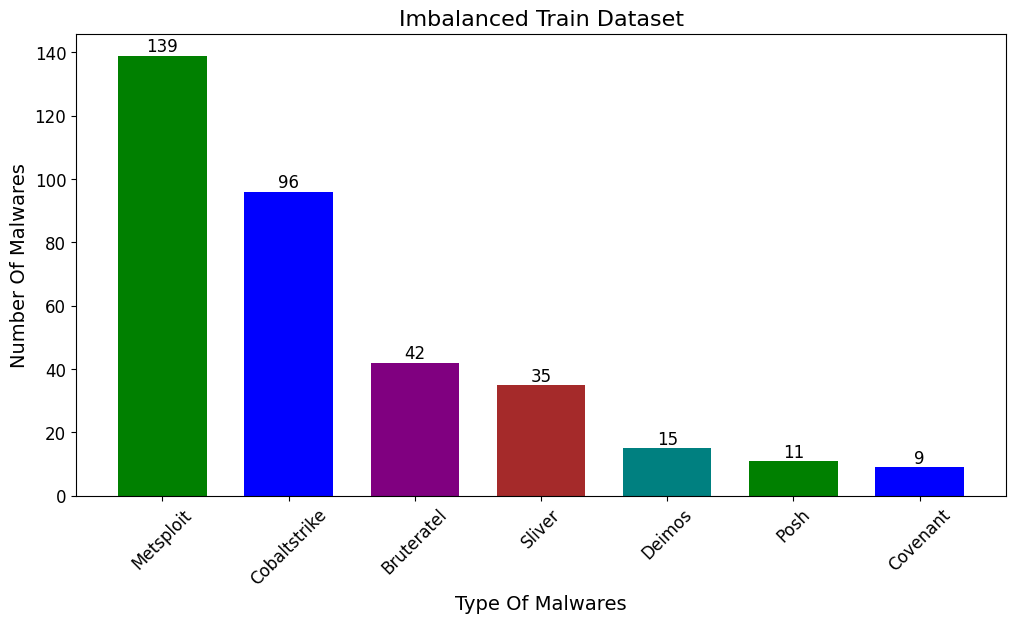

In [15]:
plot_dataset(y_train, "Imbalanced Train Dataset")

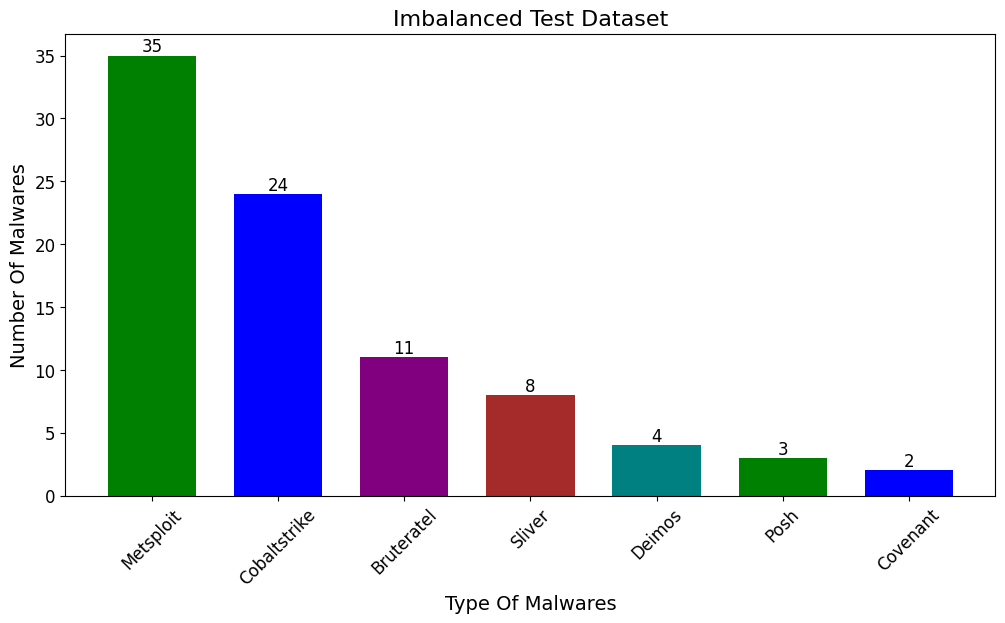

In [16]:
plot_dataset(y_test, "Imbalanced Test Dataset")

#Dataset Balancing

Train data balancing

In [17]:
class_counts = y_train.value_counts()
target_count = 40

balanced_X_train = pd.DataFrame()
balanced_y_train = pd.Series()

for label, count in class_counts.items():
    # Under-sampling
    if count < target_count:
        sampled_X_train = resample(X_train[y_train == label], n_samples=target_count, replace=True)
        sampled_y_train = pd.Series([label] * target_count)
    # Over-sampling
    elif count > target_count:
        sampled_X_train = resample(X_train[y_train == label], n_samples=target_count, replace=False)
        sampled_y_train = pd.Series([label] * target_count)
    else:
        sampled_X_train = X_train[y_train == label]
        sampled_y_train = pd.Series([label] * count)

    balanced_X_train = pd.concat([balanced_X_train, sampled_X_train])
    balanced_y_train = pd.concat([balanced_y_train, sampled_y_train])

X_train_balanced = balanced_X_train
y_train_balanced = balanced_y_train

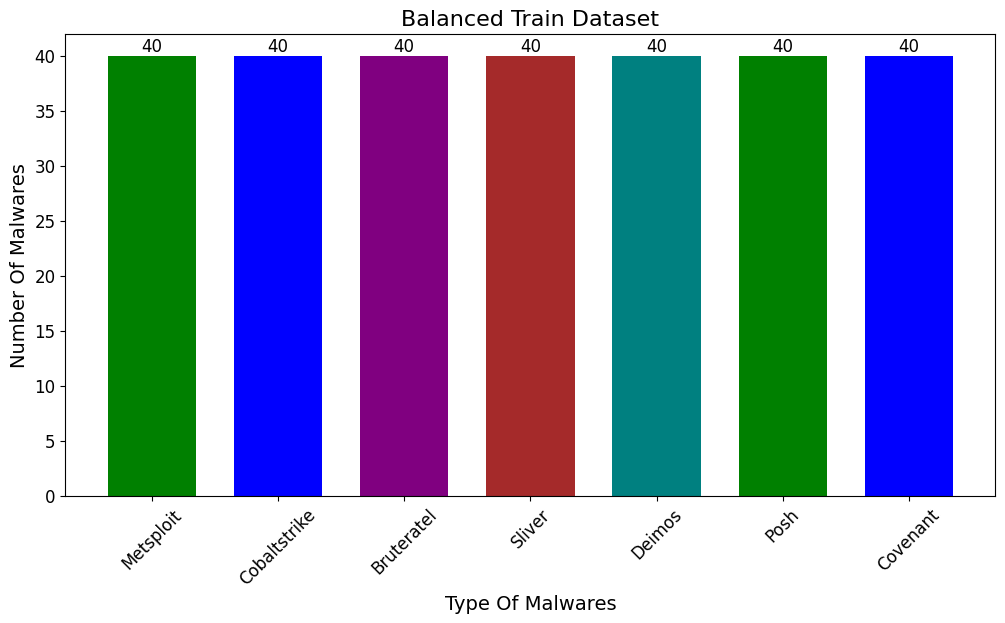

In [18]:
plot_dataset(y_train_balanced, "Balanced Train Dataset")

Test data balancing

In [19]:
class_counts_test = y_test.value_counts()
target_count_test = 10

balanced_X_test = pd.DataFrame()
balanced_y_test = pd.Series()

for label, count in class_counts_test.items():
    # Under-sampling
    if count < target_count_test:
        sampled_X_test = resample(X_test[y_test == label], n_samples=target_count_test, replace=True)
        sampled_y_test = pd.Series([label] * target_count_test)
    # Over-sampling
    elif count > target_count_test:
        sampled_X_test = resample(X_test[y_test == label], n_samples=target_count_test, replace=False)
        sampled_y_test = pd.Series([label] * target_count_test)
    else:
        sampled_X_test = X_test[y_test == label]
        sampled_y_test = pd.Series([label] * count)

    balanced_X_test = pd.concat([balanced_X_test, sampled_X_test])
    balanced_y_test = pd.concat([balanced_y_test, sampled_y_test])

X_test_balanced = balanced_X_test
y_test_balanced = balanced_y_test

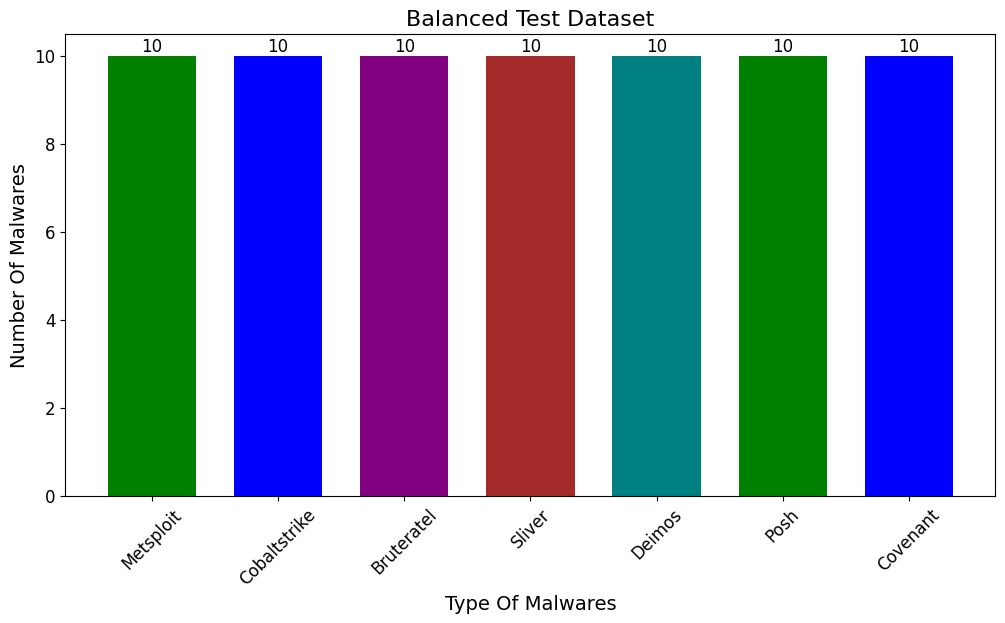

In [20]:
plot_dataset(y_test_balanced, "Balanced Test Dataset")

#Data Unpacking

In [21]:
for i in range(vec_dim):
    X_train_balanced[f"data_element_{i}"] = X_train_balanced["data_vector"].apply(lambda x: x[i])
    X_test_balanced[f"data_element_{i}"] = X_test_balanced["data_vector"].apply(lambda x: x[i])

In [22]:
X_train_balanced = X_train_balanced.drop(columns=["data_vector"])
X_test_balanced = X_test_balanced.drop(columns=["data_vector"])

In [23]:
X_train_balanced

,node,edge,data_element_0,data_element_1,data_element_2,data_element_3,data_element_4,data_element_5,data_element_6,data_element_7,...,data_element_22,data_element_23,data_element_24,data_element_25,data_element_26,data_element_27,data_element_28,data_element_29,data_element_30,data_element_31
283,517,633,48.781193,24.544752,20.762024,17.491964,16.590656,15.929210,14.044726,12.790781,...,4.348001,3.784844,3.362907,2.712057,2.494442,2.236048,1.410078,0.977823,0.449304,0.057533
227,0,0,3.297616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
255,0,0,32.869404,27.575089,17.258493,10.488708,9.488431,7.499591,5.084213,4.865176,...,0.448858,0.326314,0.211550,0.161421,0.140165,0.100249,0.088441,0.062774,0.039292,0.024758
280,0,0,48.781193,24.544752,20.762024,17.491964,16.590656,15.929210,14.044726,12.790781,...,4.348001,3.784844,3.362907,2.712057,2.494442,2.236048,1.410078,0.977823,0.449304,0.057533
242,11,12,3.297616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0,0,24.229662,17.251802,10.048819,5.344521,4.599325,3.742601,2.653730,2.624649,...,0.300398,0.256164,0.206633,0.139158,0.131038,0.118195,0.072190,0.040896,0.038134,0.010852
177,0,0,25.528959,13.094596,8.295192,4.922859,3.995057,3.541269,2.599977,2.312632,...,0.139943,0.128659,0.114219,0.100652,0.076724,0.070042,0.054170,0.016987,0.011702,0.005409
180,0,0,3.297616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
182,0,0,36.778412,22.789696,21.211260,18.331106,15.929861,13.777864,12.127740,11.079413,...,2.011951,1.572329,1.323802,1.034851,0.917029,0.658419,0.483139,0.409313,0.220059,0.050886


In [24]:
X_test_balanced

,node,edge,data_element_0,data_element_1,data_element_2,data_element_3,data_element_4,data_element_5,data_element_6,data_element_7,...,data_element_22,data_element_23,data_element_24,data_element_25,data_element_26,data_element_27,data_element_28,data_element_29,data_element_30,data_element_31
233,0,0,3.399653,0.497672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
289,0,0,26.092100,13.290772,10.597168,8.319488,7.121962,5.769242,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
334,0,0,48.175594,23.704168,20.939098,18.676931,17.133713,15.666441,15.090621,13.436112,...,3.835870,3.104959,2.994749,2.424008,2.170316,1.532880,0.794779,0.585709,0.370758,0.088514
211,0,0,3.297616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
375,0,0,46.776424,34.212410,20.386677,17.578316,15.372933,13.630003,12.449780,11.604753,...,2.958375,2.452196,2.363465,2.059263,1.492851,1.370935,0.912795,0.680081,0.451733,0.019342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,189,94,3.376523,0.407507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
179,189,94,3.376523,0.407507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
179,189,94,3.376523,0.407507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
176,0,0,24.229662,17.251802,10.048819,5.344521,4.599325,3.742601,2.653730,2.624649,...,0.300398,0.256164,0.206633,0.139158,0.131038,0.118195,0.072190,0.040896,0.038134,0.010852


#Classifier

Grid Search

In [ ]:
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10]
}

param_grid_xgb = {
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [100, 200, 300],
    "max_depth": [6, 8, 10],
    "min_child_weight": [1, 3, 5]
}

param_grid_lgbm = {
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [100, 200, 300],
    "max_depth": [6, 8, 10],
    "min_child_samples": [10, 20, 30]
}

param_grid_catboost = {
    "iterations": [100, 200, 300],
    "learning_rate": [0.1, 0.01, 0.001]
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5)
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid_xgb, cv=5)
grid_search_lgbm = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_grid_lgbm, cv=5)
grid_search_catboost = GridSearchCV(estimator=CatBoostClassifier(), param_grid=param_grid_catboost, cv=5)

grid_search_rf.fit(X_train_balanced, y_train_balanced)
grid_search_xgb.fit(X_train_balanced, y_train_balanced)
grid_search_lgbm.fit(X_train_balanced, y_train_balanced)
grid_search_catboost.fit(X_train_balanced, y_train_balanced)

print("Random Forest Best Parameters:", grid_search_rf.best_params_)
print("XGBoost Best Parameters:", grid_search_xgb.best_params_)
print("LightGBM Best Parameters:", grid_search_lgbm.best_params_)
print("CatBoost Best Parameters:", grid_search_catboost.best_params_)
'''

'\nparam_grid_rf = {\n    "n_estimators": [100, 200, 300],\n    "max_depth": [10, 20, 30],\n    "min_samples_split": [2, 5, 10]\n}\n\nparam_grid_xgb = {\n    "learning_rate": [0.1, 0.01, 0.001],\n    "n_estimators": [100, 200, 300],\n    "max_depth": [6, 8, 10],\n    "min_child_weight": [1, 3, 5]\n}\n\nparam_grid_lgbm = {\n    "learning_rate": [0.1, 0.01, 0.001],\n    "n_estimators": [100, 200, 300],\n    "max_depth": [6, 8, 10],\n    "min_child_samples": [10, 20, 30]\n}\n\nparam_grid_svc = {\n    "C": [0.1, 1, 10],\n    "kernel": ["rbf"],\n    "gamma": ["scale"]\n}\n\nparam_grid_catboost = {\n    "iterations": [100, 200, 300],\n    "learning_rate": [0.1, 0.01, 0.001]\n}\n\ngrid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5)\ngrid_search_xgb = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid_xgb, cv=5)\ngrid_search_lgbm = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_grid_lgbm, cv=5)\n#grid_search_svc = GridSearchCV

In [32]:
rf_classifier = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=2
)

xgb_classifier = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    min_child_weight=1
)

lgbm_classifier = LGBMClassifier(
    learning_rate=0.01,
    max_depth=6,
    min_child_samples=10,
    n_estimators=300
)

svc_classifier = SVC(
    C=10.0,
    kernel="rbf",
    gamma="scale"
)

catboost_classifier = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1
)

classifiers = [
    rf_classifier,
    xgb_classifier,
    lgbm_classifier,
    svc_classifier,
    catboost_classifier
]

Train

In [33]:
results = {clf.__class__.__name__: {"accuracy": [], "precision": [], "recall": [], "f1": []} for clf in classifiers}

In [34]:
for clf in classifiers:
    for _ in tqdm(range(10)):
        clf.fit(X_train_balanced, y_train_balanced)
        y_pred = clf.predict(X_test_balanced)
        accuracy = accuracy_score(y_test_balanced, y_pred)
        precision = precision_score(y_test_balanced, y_pred, average="weighted")
        recall = recall_score(y_test_balanced, y_pred, average="weighted")
        f1 = f1_score(y_test_balanced, y_pred, average="weighted")

        results[clf.__class__.__name__]["accuracy"].append(accuracy)
        results[clf.__class__.__name__]["precision"].append(precision)
        results[clf.__class__.__name__]["recall"].append(recall)
        results[clf.__class__.__name__]["f1"].append(f1)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 34
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] 

 10%|█         | 1/10 [00:01<00:10,  1.21s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 34
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910

 20%|██        | 2/10 [00:02<00:11,  1.41s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 34
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score

 30%|███       | 3/10 [00:04<00:09,  1.35s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 34
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910

 40%|████      | 4/10 [00:05<00:07,  1.25s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 34
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910

 50%|█████     | 5/10 [00:06<00:06,  1.20s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 34
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910

 60%|██████    | 6/10 [00:07<00:04,  1.17s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 34
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910

 70%|███████   | 7/10 [00:08<00:03,  1.14s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 34
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score

 80%|████████  | 8/10 [00:09<00:02,  1.13s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 34
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score

 90%|█████████ | 9/10 [00:10<00:01,  1.11s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 34
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 1.7918622	total: 29ms	remaining: 2.87s
1:	learn: 1.6964459	total: 46.4ms	remaining: 2.27s
2:	learn: 1.5901327	total: 60.2ms	remaining: 1.94s
3:	learn: 1.5234796	total: 69.5ms	remaining: 1.67s
4:	learn: 1.4523262	total: 81.5ms	remaining: 1.55s
5:	learn: 1.3939210	total: 93.2ms	remaining: 1.46s
6:	learn: 1.3345762	total: 103ms	remaining: 1.37s
7:	learn: 1.2866159	total: 113ms	remaining: 1.29s
8:	learn: 1.2402068	total: 125ms	remaining: 1.26s
9:	learn: 1.2032877	total: 136ms	remaining: 1.23s
10:	learn: 1.1661786	total: 149ms	remaining: 1.2s
11:	learn: 1.1298674	total: 160ms	remaining: 1.18s
12:	learn: 1.1015556	total: 172ms	remaining: 1.15s
13:	learn: 1.0735800	total: 182ms	remaining: 1.12s
14:	learn: 1.0413886	total: 192ms	remaining: 1.09s
15:	learn: 1.0152801	total: 202ms	remaining: 1.06s
16:	learn: 0.9960287	total: 211ms	remaining: 1.03s
17:	learn: 0.9758235	total: 221ms	remaining: 1.01s
18:	learn: 0.9534291	total: 242ms	remaining: 1.03s
19:	learn: 0.9373777	total: 256ms	rema

 10%|█         | 1/10 [00:01<00:10,  1.22s/it]

91:	learn: 0.4419500	total: 1.06s	remaining: 92.6ms
92:	learn: 0.4406852	total: 1.08s	remaining: 81.3ms
93:	learn: 0.4354891	total: 1.09s	remaining: 69.9ms
94:	learn: 0.4329110	total: 1.1s	remaining: 58.1ms
95:	learn: 0.4299688	total: 1.11s	remaining: 46.4ms
96:	learn: 0.4277392	total: 1.12s	remaining: 34.7ms
97:	learn: 0.4258177	total: 1.13s	remaining: 23.1ms
98:	learn: 0.4226590	total: 1.14s	remaining: 11.5ms
99:	learn: 0.4193678	total: 1.15s	remaining: 0us
0:	learn: 1.7918622	total: 15.1ms	remaining: 1.5s
1:	learn: 1.6964459	total: 24.4ms	remaining: 1.2s
2:	learn: 1.5901327	total: 34.1ms	remaining: 1.1s
3:	learn: 1.5234796	total: 43.4ms	remaining: 1.04s
4:	learn: 1.4523262	total: 52.6ms	remaining: 1s
5:	learn: 1.3939210	total: 62.6ms	remaining: 981ms
6:	learn: 1.3345762	total: 77.5ms	remaining: 1.03s
7:	learn: 1.2866159	total: 93.9ms	remaining: 1.08s
8:	learn: 1.2402068	total: 115ms	remaining: 1.17s
9:	learn: 1.2032877	total: 126ms	remaining: 1.13s
10:	learn: 1.1661786	total: 137ms	

 20%|██        | 2/10 [00:02<00:12,  1.55s/it]

94:	learn: 0.4329110	total: 1.58s	remaining: 83.3ms
95:	learn: 0.4299688	total: 1.61s	remaining: 67.2ms
96:	learn: 0.4277392	total: 1.63s	remaining: 50.5ms
97:	learn: 0.4258177	total: 1.65s	remaining: 33.7ms
98:	learn: 0.4226590	total: 1.66s	remaining: 16.8ms
99:	learn: 0.4193678	total: 1.68s	remaining: 0us
0:	learn: 1.7918622	total: 41.4ms	remaining: 4.1s
1:	learn: 1.6964459	total: 59.3ms	remaining: 2.9s
2:	learn: 1.5901327	total: 79.1ms	remaining: 2.56s
3:	learn: 1.5234796	total: 96.3ms	remaining: 2.31s
4:	learn: 1.4523262	total: 120ms	remaining: 2.29s
5:	learn: 1.3939210	total: 140ms	remaining: 2.19s
6:	learn: 1.3345762	total: 158ms	remaining: 2.1s
7:	learn: 1.2866159	total: 178ms	remaining: 2.05s
8:	learn: 1.2402068	total: 197ms	remaining: 1.99s
9:	learn: 1.2032877	total: 215ms	remaining: 1.93s
10:	learn: 1.1661786	total: 232ms	remaining: 1.88s
11:	learn: 1.1298674	total: 250ms	remaining: 1.83s
12:	learn: 1.1015556	total: 271ms	remaining: 1.82s
13:	learn: 1.0735800	total: 290ms	rem

 30%|███       | 3/10 [00:04<00:11,  1.65s/it]

86:	learn: 0.4569092	total: 1.53s	remaining: 229ms
87:	learn: 0.4539290	total: 1.54s	remaining: 211ms
88:	learn: 0.4511727	total: 1.56s	remaining: 194ms
89:	learn: 0.4492357	total: 1.57s	remaining: 175ms
90:	learn: 0.4453324	total: 1.58s	remaining: 157ms
91:	learn: 0.4419500	total: 1.59s	remaining: 139ms
92:	learn: 0.4406852	total: 1.6s	remaining: 121ms
93:	learn: 0.4354891	total: 1.61s	remaining: 103ms
94:	learn: 0.4329110	total: 1.62s	remaining: 85.5ms
95:	learn: 0.4299688	total: 1.63s	remaining: 68.1ms
96:	learn: 0.4277392	total: 1.64s	remaining: 50.9ms
97:	learn: 0.4258177	total: 1.65s	remaining: 33.8ms
98:	learn: 0.4226590	total: 1.66s	remaining: 16.8ms
99:	learn: 0.4193678	total: 1.67s	remaining: 0us
0:	learn: 1.7918622	total: 25.4ms	remaining: 2.51s
1:	learn: 1.6964459	total: 42.9ms	remaining: 2.1s
2:	learn: 1.5901327	total: 53ms	remaining: 1.71s
3:	learn: 1.5234796	total: 62.5ms	remaining: 1.5s
4:	learn: 1.4523262	total: 77.1ms	remaining: 1.47s
5:	learn: 1.3939210	total: 88.3ms

 40%|████      | 4/10 [00:05<00:08,  1.46s/it]

95:	learn: 0.4299688	total: 1.07s	remaining: 44.6ms
96:	learn: 0.4277392	total: 1.09s	remaining: 33.7ms
97:	learn: 0.4258177	total: 1.1s	remaining: 22.4ms
98:	learn: 0.4226590	total: 1.11s	remaining: 11.2ms
99:	learn: 0.4193678	total: 1.12s	remaining: 0us
0:	learn: 1.7918622	total: 20.8ms	remaining: 2.06s
1:	learn: 1.6964459	total: 31.4ms	remaining: 1.54s
2:	learn: 1.5901327	total: 41.7ms	remaining: 1.35s
3:	learn: 1.5234796	total: 50.8ms	remaining: 1.22s
4:	learn: 1.4523262	total: 60.8ms	remaining: 1.15s
5:	learn: 1.3939210	total: 73.2ms	remaining: 1.15s
6:	learn: 1.3345762	total: 86.5ms	remaining: 1.15s
7:	learn: 1.2866159	total: 102ms	remaining: 1.17s
8:	learn: 1.2402068	total: 117ms	remaining: 1.18s
9:	learn: 1.2032877	total: 132ms	remaining: 1.18s
10:	learn: 1.1661786	total: 145ms	remaining: 1.17s
11:	learn: 1.1298674	total: 158ms	remaining: 1.16s
12:	learn: 1.1015556	total: 170ms	remaining: 1.14s
13:	learn: 1.0735800	total: 181ms	remaining: 1.11s
14:	learn: 1.0413886	total: 191ms

 50%|█████     | 5/10 [00:07<00:06,  1.36s/it]

86:	learn: 0.4569092	total: 990ms	remaining: 148ms
87:	learn: 0.4539290	total: 1s	remaining: 137ms
88:	learn: 0.4511727	total: 1.01s	remaining: 125ms
89:	learn: 0.4492357	total: 1.02s	remaining: 114ms
90:	learn: 0.4453324	total: 1.03s	remaining: 102ms
91:	learn: 0.4419500	total: 1.04s	remaining: 90.7ms
92:	learn: 0.4406852	total: 1.05s	remaining: 79.2ms
93:	learn: 0.4354891	total: 1.06s	remaining: 67.8ms
94:	learn: 0.4329110	total: 1.07s	remaining: 56.4ms
95:	learn: 0.4299688	total: 1.08s	remaining: 45ms
96:	learn: 0.4277392	total: 1.09s	remaining: 33.8ms
97:	learn: 0.4258177	total: 1.1s	remaining: 22.5ms
98:	learn: 0.4226590	total: 1.11s	remaining: 11.3ms
99:	learn: 0.4193678	total: 1.13s	remaining: 0us
0:	learn: 1.7918622	total: 18.6ms	remaining: 1.84s
1:	learn: 1.6964459	total: 40.9ms	remaining: 2s
2:	learn: 1.5901327	total: 53.4ms	remaining: 1.73s
3:	learn: 1.5234796	total: 63ms	remaining: 1.51s
4:	learn: 1.4523262	total: 72.9ms	remaining: 1.39s
5:	learn: 1.3939210	total: 83.2ms	re

 60%|██████    | 6/10 [00:08<00:05,  1.31s/it]

98:	learn: 0.4226590	total: 1.12s	remaining: 11.4ms
99:	learn: 0.4193678	total: 1.14s	remaining: 0us
0:	learn: 1.7918622	total: 15.5ms	remaining: 1.53s
1:	learn: 1.6964459	total: 24.9ms	remaining: 1.22s
2:	learn: 1.5901327	total: 34.5ms	remaining: 1.11s
3:	learn: 1.5234796	total: 43.6ms	remaining: 1.04s
4:	learn: 1.4523262	total: 53.7ms	remaining: 1.02s
5:	learn: 1.3939210	total: 65ms	remaining: 1.02s
6:	learn: 1.3345762	total: 74.7ms	remaining: 992ms
7:	learn: 1.2866159	total: 84.2ms	remaining: 968ms
8:	learn: 1.2402068	total: 93.9ms	remaining: 949ms
9:	learn: 1.2032877	total: 103ms	remaining: 931ms
10:	learn: 1.1661786	total: 114ms	remaining: 921ms
11:	learn: 1.1298674	total: 123ms	remaining: 904ms
12:	learn: 1.1015556	total: 133ms	remaining: 891ms
13:	learn: 1.0735800	total: 152ms	remaining: 933ms
14:	learn: 1.0413886	total: 169ms	remaining: 960ms
15:	learn: 1.0152801	total: 180ms	remaining: 944ms
16:	learn: 0.9960287	total: 190ms	remaining: 925ms
17:	learn: 0.9758235	total: 200ms	r

 70%|███████   | 7/10 [00:09<00:03,  1.26s/it]

90:	learn: 0.4453324	total: 1.01s	remaining: 100ms
91:	learn: 0.4419500	total: 1.02s	remaining: 88.8ms
92:	learn: 0.4406852	total: 1.03s	remaining: 77.5ms
93:	learn: 0.4354891	total: 1.04s	remaining: 66.4ms
94:	learn: 0.4329110	total: 1.05s	remaining: 55.2ms
95:	learn: 0.4299688	total: 1.06s	remaining: 44.1ms
96:	learn: 0.4277392	total: 1.07s	remaining: 33ms
97:	learn: 0.4258177	total: 1.08s	remaining: 22ms
98:	learn: 0.4226590	total: 1.09s	remaining: 11ms
99:	learn: 0.4193678	total: 1.1s	remaining: 0us
0:	learn: 1.7918622	total: 18ms	remaining: 1.78s
1:	learn: 1.6964459	total: 27.3ms	remaining: 1.34s
2:	learn: 1.5901327	total: 37ms	remaining: 1.2s
3:	learn: 1.5234796	total: 47.8ms	remaining: 1.15s
4:	learn: 1.4523262	total: 57.3ms	remaining: 1.09s
5:	learn: 1.3939210	total: 67.5ms	remaining: 1.06s
6:	learn: 1.3345762	total: 87.6ms	remaining: 1.16s
7:	learn: 1.2866159	total: 100ms	remaining: 1.15s
8:	learn: 1.2402068	total: 111ms	remaining: 1.12s
9:	learn: 1.2032877	total: 122ms	remain

 80%|████████  | 8/10 [00:10<00:02,  1.23s/it]

0:	learn: 1.7918622	total: 24.7ms	remaining: 2.45s
1:	learn: 1.6964459	total: 42.1ms	remaining: 2.06s
2:	learn: 1.5901327	total: 54.7ms	remaining: 1.77s
3:	learn: 1.5234796	total: 63.8ms	remaining: 1.53s
4:	learn: 1.4523262	total: 73ms	remaining: 1.39s
5:	learn: 1.3939210	total: 82.9ms	remaining: 1.3s
6:	learn: 1.3345762	total: 92.3ms	remaining: 1.23s
7:	learn: 1.2866159	total: 101ms	remaining: 1.17s
8:	learn: 1.2402068	total: 114ms	remaining: 1.15s
9:	learn: 1.2032877	total: 123ms	remaining: 1.11s
10:	learn: 1.1661786	total: 135ms	remaining: 1.09s
11:	learn: 1.1298674	total: 145ms	remaining: 1.06s
12:	learn: 1.1015556	total: 155ms	remaining: 1.04s
13:	learn: 1.0735800	total: 166ms	remaining: 1.02s
14:	learn: 1.0413886	total: 176ms	remaining: 996ms
15:	learn: 1.0152801	total: 186ms	remaining: 976ms
16:	learn: 0.9960287	total: 195ms	remaining: 954ms
17:	learn: 0.9758235	total: 205ms	remaining: 935ms
18:	learn: 0.9534291	total: 215ms	remaining: 916ms
19:	learn: 0.9373777	total: 229ms	rem

 90%|█████████ | 9/10 [00:11<00:01,  1.22s/it]

94:	learn: 0.4329110	total: 1.06s	remaining: 55.8ms
95:	learn: 0.4299688	total: 1.08s	remaining: 44.8ms
96:	learn: 0.4277392	total: 1.08s	remaining: 33.6ms
97:	learn: 0.4258177	total: 1.09s	remaining: 22.3ms
98:	learn: 0.4226590	total: 1.1s	remaining: 11.2ms
99:	learn: 0.4193678	total: 1.11s	remaining: 0us
0:	learn: 1.7918622	total: 21.2ms	remaining: 2.1s
1:	learn: 1.6964459	total: 31.2ms	remaining: 1.53s
2:	learn: 1.5901327	total: 41.3ms	remaining: 1.33s
3:	learn: 1.5234796	total: 50.8ms	remaining: 1.22s
4:	learn: 1.4523262	total: 60.5ms	remaining: 1.15s
5:	learn: 1.3939210	total: 71ms	remaining: 1.11s
6:	learn: 1.3345762	total: 81.2ms	remaining: 1.08s
7:	learn: 1.2866159	total: 90.9ms	remaining: 1.04s
8:	learn: 1.2402068	total: 101ms	remaining: 1.02s
9:	learn: 1.2032877	total: 116ms	remaining: 1.04s
10:	learn: 1.1661786	total: 136ms	remaining: 1.1s
11:	learn: 1.1298674	total: 146ms	remaining: 1.07s
12:	learn: 1.1015556	total: 156ms	remaining: 1.04s
13:	learn: 1.0735800	total: 166ms	r

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]

85:	learn: 0.4616529	total: 948ms	remaining: 154ms
86:	learn: 0.4569092	total: 966ms	remaining: 144ms
87:	learn: 0.4539290	total: 976ms	remaining: 133ms
88:	learn: 0.4511727	total: 985ms	remaining: 122ms
89:	learn: 0.4492357	total: 995ms	remaining: 111ms
90:	learn: 0.4453324	total: 1.01s	remaining: 99.5ms
91:	learn: 0.4419500	total: 1.02s	remaining: 88.5ms
92:	learn: 0.4406852	total: 1.03s	remaining: 77.3ms
93:	learn: 0.4354891	total: 1.04s	remaining: 66.2ms
94:	learn: 0.4329110	total: 1.05s	remaining: 55.1ms
95:	learn: 0.4299688	total: 1.05s	remaining: 44ms
96:	learn: 0.4277392	total: 1.06s	remaining: 33ms
97:	learn: 0.4258177	total: 1.07s	remaining: 21.9ms
98:	learn: 0.4226590	total: 1.08s	remaining: 11ms
99:	learn: 0.4193678	total: 1.09s	remaining: 0us


Evaluation

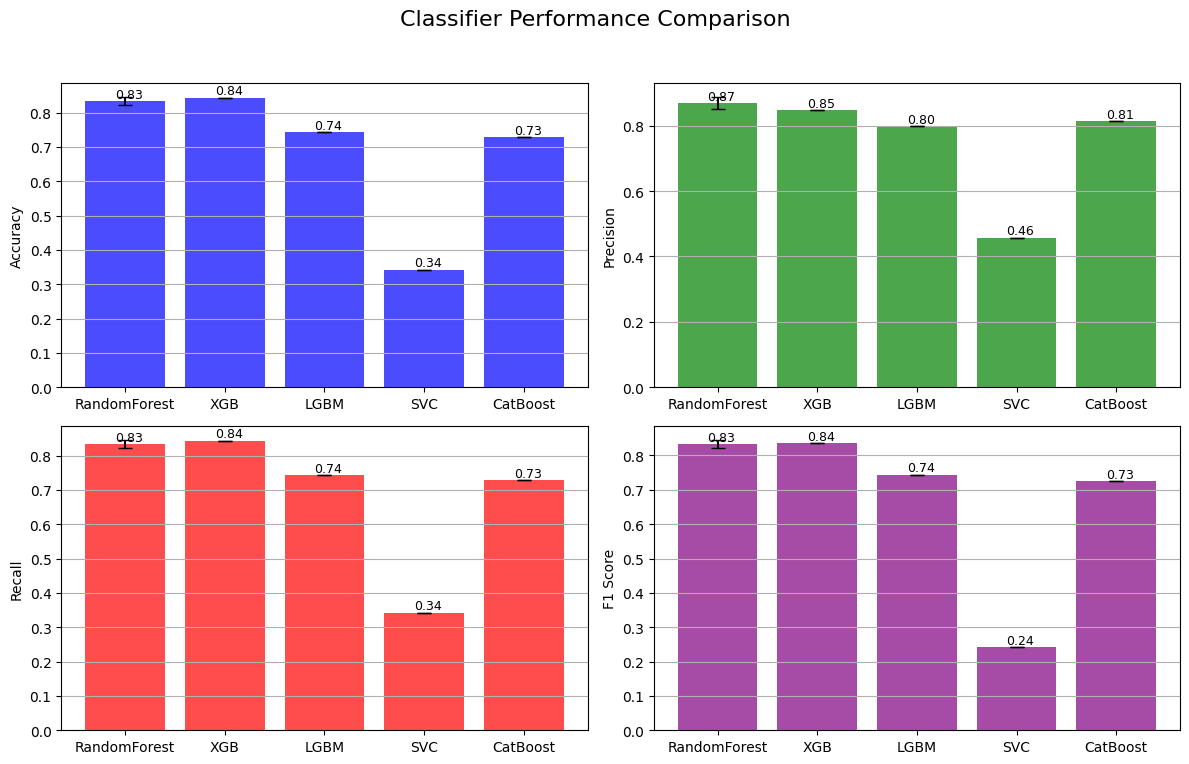

[Text(0, 0, 'RandomForest'),
 Text(1, 0, 'XGB'),
 Text(2, 0, 'LGBM'),
 Text(3, 0, 'SVC'),
 Text(4, 0, 'CatBoost')]

In [35]:
classifiers_names = [clf.__class__.__name__ for clf in classifiers]
accuracy_means = [np.mean(results[clf_name]["accuracy"]) for clf_name in classifiers_names]
precision_means = [np.mean(results[clf_name]["precision"]) for clf_name in classifiers_names]
recall_means = [np.mean(results[clf_name]["recall"]) for clf_name in classifiers_names]
f1_means = [np.mean(results[clf_name]["f1"]) for clf_name in classifiers_names]

accuracy_stds = [np.std(results[clf_name]["accuracy"]) for clf_name in classifiers_names]
precision_stds = [np.std(results[clf_name]["precision"]) for clf_name in classifiers_names]
recall_stds = [np.std(results[clf_name]["recall"]) for clf_name in classifiers_names]
f1_stds = [np.std(results[clf_name]["f1"]) for clf_name in classifiers_names]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Classifier Performance Comparison", fontsize=16)
classifiers_names = [clf.__class__.__name__.replace("Classifier", "") for clf in classifiers]

# Accuracy
bars = axes[0, 0].bar(classifiers_names, accuracy_means, yerr=accuracy_stds, capsize=5, color="b", alpha=0.7)
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].grid(axis="y")
axes[0, 0].tick_params(axis="x")
for bar, acc in zip(bars, accuracy_means):
    axes[0, 0].text(bar.get_x() + bar.get_width() / 2 - 0.1, acc + 0.01, f"{acc:.2f}", fontsize=9)

# Precision
bars = axes[0, 1].bar(classifiers_names, precision_means, yerr=precision_stds, capsize=5, color="g", alpha=0.7)
axes[0, 1].set_ylabel("Precision")
axes[0, 1].grid(axis="y")
axes[0, 1].tick_params(axis="x")
for bar, prec in zip(bars, precision_means):
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2 - 0.1, prec + 0.01, f"{prec:.2f}", fontsize=9)

# Recall
bars = axes[1, 0].bar(classifiers_names, recall_means, yerr=recall_stds, capsize=5, color="r", alpha=0.7)
axes[1, 0].set_ylabel("Recall")
axes[1, 0].grid(axis="y")
axes[1, 0].tick_params(axis="x")
for bar, rec in zip(bars, recall_means):
    axes[1, 0].text(bar.get_x() + bar.get_width() / 2 - 0.1, rec + 0.01, f"{rec:.2f}", fontsize=9)

# F1 Score
bars = axes[1, 1].bar(classifiers_names, f1_means, yerr=f1_stds, capsize=5, color="purple", alpha=0.7)
axes[1, 1].set_ylabel("F1 Score")
axes[1, 1].grid(axis="y")
axes[1, 1].tick_params(axis="x")
for bar, f1 in zip(bars, f1_means):
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2 - 0.1, f1 + 0.01, f"{f1:.2f}", fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


axes[0, 0].set_xticklabels(classifiers_names, rotation=45)
axes[0, 1].set_xticklabels(classifiers_names, rotation=45)
axes[1, 0].set_xticklabels(classifiers_names, rotation=45)
axes[1, 1].set_xticklabels(classifiers_names, rotation=45)